## How do we sample points for the problem? 2D

In [1]:
# Essential libraries
import os
import random
import itertools
from itertools import product, combinations
import multiprocessing

# Numeric computation
import numpy as np
import torch
import scipy  # For linear algebra (e.g., Cholesky decomposition)
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from numpy.polynomial.hermite import hermgauss  # Polynomials of the form e^(-x^2)
from numpy.polynomial.hermite_e import hermegauss  # Polynomials of the form e^(-x^(2)/2)
from scipy.special import roots_hermite, roots_hermitenorm

# Gaussian Process Regression (GPR)
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import (Kernel, ScaleKernel, MaternKernel, 
                              GridInterpolationKernel, ProductKernel)
from gpytorch.utils.grid import choose_grid_size
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from torch.nn import ModuleList  # Correct import for ModuleList (For SKIP)
from gpytorch.variational import (CholeskyVariationalDistribution, 
                                  VariationalStrategy)  # For SVGP
from gpytorch.lazy import MatmulLazyTensor, InterpolatedLazyTensor
from gpytorch.settings import fast_pred_var

# Optimization
import cyipopt
from cyipopt import Problem

# Quasi-Monte Carlo (QMC) and sparse grids
import Tasmanian  # Tasmanian Sparse Grid library
from torch.quasirandom import SobolEngine
import chaospy as cp

# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
import scienceplots  # For custom style based on science plots

# Parallel processing
from joblib import Parallel, delayed

# Logging configuration
import logging
logging.basicConfig(filename='optimization_log.txt', 
                    filemode='w',
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Random seed setup
random_seed = 20011210
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
multiprocessing.set_start_method('spawn', force=True)

In [2]:
plt.style.use('science')

custom = True
if custom:

    colors = ['#094a84','#cc2300', 
                '#009437', '#cc7700',
                '#694878', '#383838',
                '#7e7e7e']
    mpl.rcParams['axes.prop_cycle'] = cycler('color', 
                                            ['#094a84','#cc2300', 
                                            '#009437', '#cc7700',
                                            '#694878', '#383838',
                                            '#7e7e7e'])

    mpl.rcParams['figure.facecolor'] = '#ffffff'  # Lightest Snow Storm background
    mpl.rcParams['axes.facecolor'] = '#FCFDFE'    # Same light background inside plots
    mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.facecolor'] = '#3B4252'    # Same light background inside plots
    # # mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.edgecolor'] = '#3B4252'    # Dark Slate from Polar Night for edges
    # mpl.rcParams['axes.labelcolor'] = '#3B4252'   # Text color for labels using Dark Slate
    # mpl.rcParams['xtick.color'] = '#3B4252'       # Tick color from Polar Night palette
    # mpl.rcParams['ytick.color'] = '#3B4252'

    mpl.rcParams['font.size'] = 11
    mpl.rcParams['axes.titlesize'] = 11
    mpl.rcParams['axes.labelsize'] = 11
    mpl.rcParams['legend.fontsize'] = 11

    # Remove spines
    # mpl.rcParams['axes.spines.top'] = False
    # mpl.rcParams['axes.spines.right'] = False
    # mpl.rcParams['axes.spines.bottom'] = False
    # mpl.rcParams['axes.spines.left'] = False

    # Grid settings
    mpl.rcParams['axes.grid'] = True
    mpl.rcParams['grid.color'] = '#e2e3e4'        # Subtle grid lines using light Snow Storm color
    mpl.rcParams['grid.linestyle'] = '--'
    mpl.rcParams['grid.linewidth'] = 0.8
    mpl.rcParams['axes.titlecolor'] = 'black'
    # Ticks
    mpl.rcParams['xtick.major.size'] = 5
    mpl.rcParams['ytick.major.size'] = 5
    mpl.rcParams['xtick.minor.size'] = 3
    mpl.rcParams['ytick.minor.size'] = 3
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'

    # Lines and markers
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['lines.markersize'] = 6
    mpl.rcParams['lines.markeredgewidth'] = 1.5

    # Legends
    mpl.rcParams['legend.frameon'] = True
    mpl.rcParams['legend.loc'] = 'best'

    # Subplots and layout
    mpl.rcParams['figure.figsize'] = [8, 6]
    mpl.rcParams['figure.dpi'] = 600
    mpl.rcParams['figure.autolayout'] = True

    # Always save as 'tight'
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.02

    # Save figures to the folder Figures
    output_folder = '../Speciale dokumentet/Figures'
    os.makedirs(output_folder, exist_ok=True)

In [5]:
import numpy as np
from scipy.spatial import ConvexHull

def point_in_convex_hull(hull, point):
    """
    Check if a point is inside the convex hull.
    
    Args:
        hull (scipy.spatial.ConvexHull): Convex hull object defining the NTR.
        point (ndarray): Point to check, shape [D].
    
    Returns:
        bool: True if the point is inside the convex hull, False otherwise.
    """
    return np.all(np.dot(hull.equations[:, :-1], point) + hull.equations[:, -1] <= 0)

def create_grid(ntr_vertices, grid_density=100):
    """
    Creates a grid of points in the simplex (sum(x_i) <= 1), excluding those inside a convex hull defined by NTR vertices.
    
    Args:
        ntr_vertices (ndarray): Vertices defining the convex hull (NTR), shape [n_vertices, D].
        grid_density (int): Number of points along each dimension.
    
    Returns:
        ndarray: Grid of points excluding the points inside the convex hull.
    """
    # Get the dimension of the problem from the NTR vertices
    D = ntr_vertices.shape[1]
    
    # Create a grid in D dimensions, each dimension ranging from 0 to 1
    grid_ranges = [np.linspace(0, 1, int(grid_density)) for _ in range(D)]
    
    # Create a meshgrid for all D dimensions and flatten it into a list of points
    grid = np.array(np.meshgrid(*grid_ranges)).T.reshape(-1, D)

    # Filter out points where the sum exceeds 1 (outside the simplex)
    simplex_mask = np.sum(grid, axis=1) <= 1

    # Keep only points inside the simplex
    points = grid[simplex_mask]

    return points

def create_grid_excluding_ntr(ntr_vertices, grid_density=100):
    """
    Creates a grid of points in the simplex (sum(x_i) <= 1), excluding those inside a convex hull defined by NTR vertices.
    
    Args:
        ntr_vertices (ndarray): Vertices defining the convex hull (NTR), shape [n_vertices, D].
        grid_density (int): Number of points along each dimension.
    
    Returns:
        ndarray: Grid of points excluding the points inside the convex hull.
    """
    # Create the convex hull from the NTR vertices
    hull = ConvexHull(ntr_vertices)

    # Create a grid of points in the simplex
    grid_points = create_grid(ntr_vertices, grid_density)

    # Filter out points inside the NTR (convex hull)
    mask = np.array([not point_in_convex_hull(hull, point) for point in grid_points])
    outside_points = grid_points[mask]

    return outside_points

def sample_points_around_ntr_separated(ntr_vertices, num_samples, kink_ratio=0.25, inside_ratio=0.25, grid_density=25):
    """
    Samples points around kinks, inside the NTR, and in the general state space excluding NTR.
    """
    hull = ConvexHull(ntr_vertices)
    delaunay = Delaunay(ntr_vertices[hull.vertices])  # Create a Delaunay triangulation for point-in-hull testing

    # Sample points inside the NTR
    num_inside = int(num_samples * inside_ratio)
    inside_points = np.array([
        np.dot(np.random.dirichlet(np.ones(len(hull.vertices)), size=1), ntr_vertices[hull.vertices]).squeeze(0)
        for _ in range(num_inside)
    ])

    # Sample points around the kinks using linear interpolation with noise
    num_kinks = int(num_samples * kink_ratio)
    kink_points = []
    for i in range(len(ntr_vertices)):
        for _ in range(num_kinks // len(ntr_vertices)):
            while True:
                alpha = np.random.uniform(1.005, 1.1)  # Interpolation factor to ensure point is outside
                beta = 1 - alpha
                point = alpha * ntr_vertices[i] + beta * ntr_vertices[(i + 1) % len(ntr_vertices)]
                point += np.random.uniform(-0.02, 0.02, size=len(ntr_vertices[0]))  # Small noise
                if not delaunay.find_simplex(point) >= 0:  # Check if point is outside the hull
                    kink_points.append(point)
                    break  # Exit loop once we have a valid point outside

    kink_points = np.array(kink_points)

    # Create a grid and exclude points inside the NTR
    general_points = create_grid_excluding_ntr(ntr_vertices, grid_density)
    num_general = num_samples - len(inside_points) - len(kink_points)
    if num_general > 0:
        general_points = general_points[np.random.choice(len(general_points), size=num_general, replace=False)]

    return inside_points, kink_points, general_points


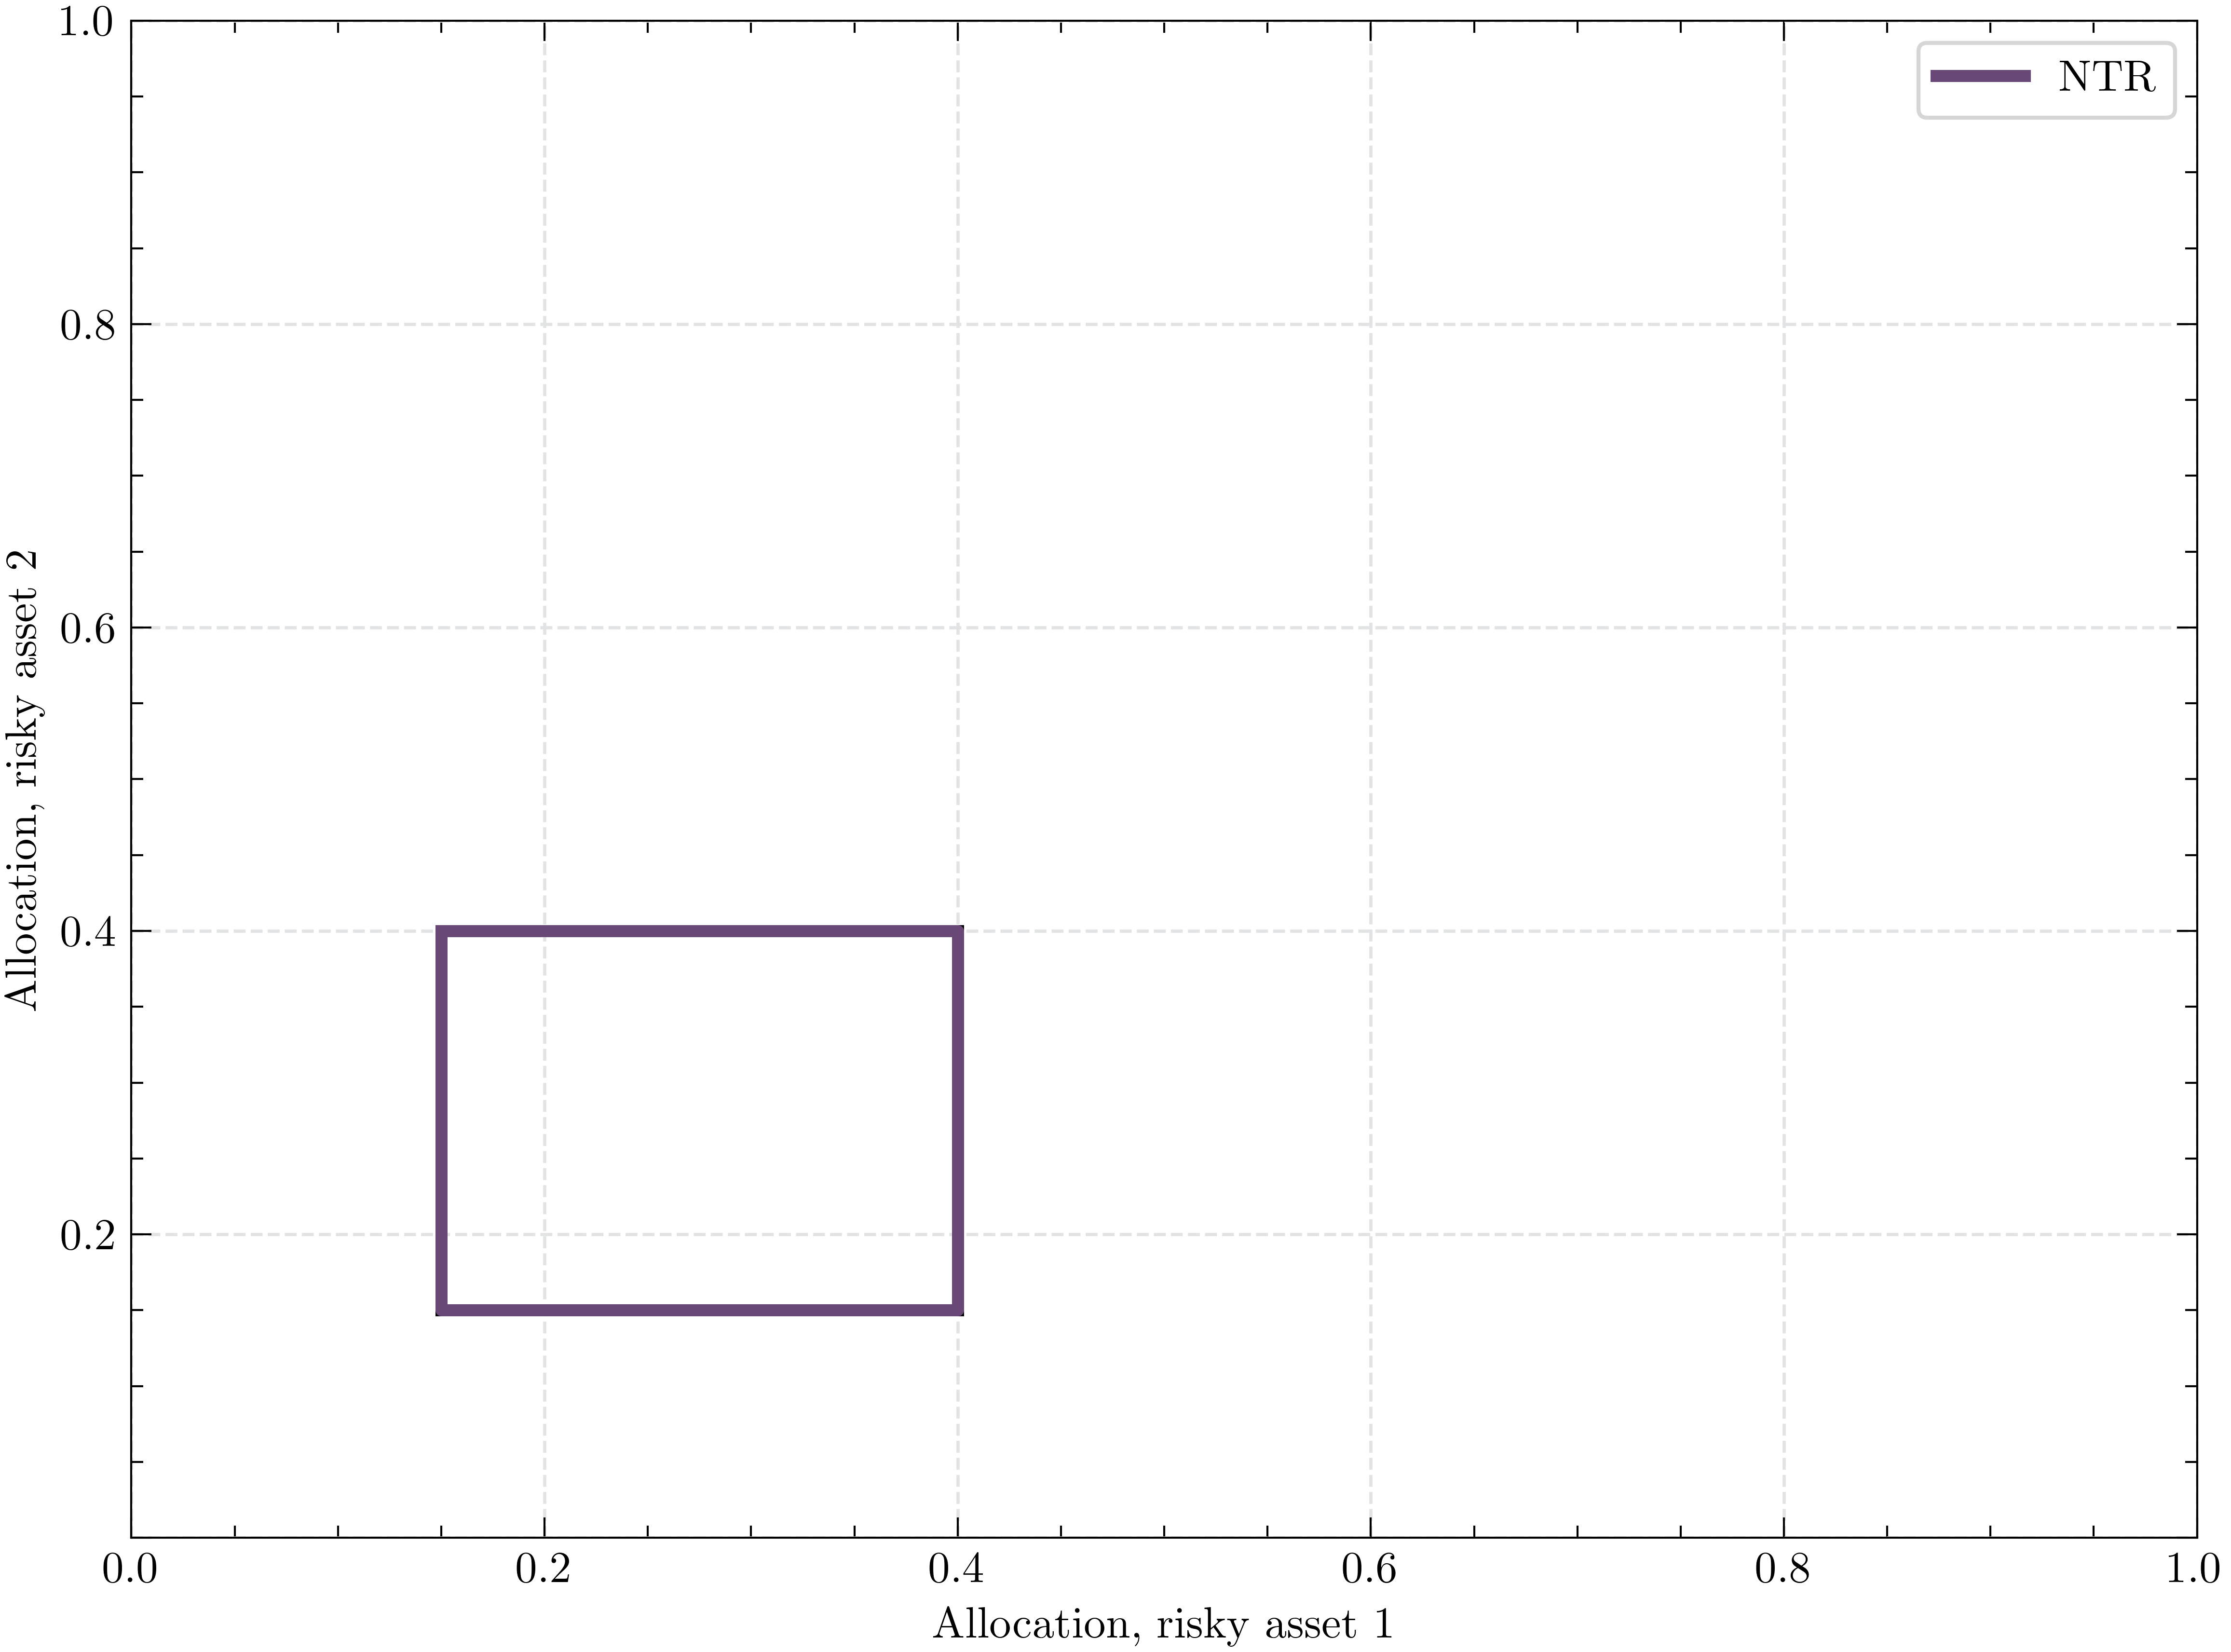

In [17]:
# Define the NTR 
ntr_vertices = np.array([
    [0.15, 0.4],
    [0.4, 0.4],
    [0.4, 0.15],
    [0.15, 0.15]
])


# Save Uniform grid plot
plt.figure(figsize=(8, 6))
# plt.title('Uniform Grid')
hull = ConvexHull(ntr_vertices)
for simplex in hull.simplices:
    plt.plot(ntr_vertices[simplex, 0], ntr_vertices[simplex, 1], 'k-')
ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR',color=colors[4])
plt.xlabel('Allocation, risky asset 1')
plt.ylabel('Allocation, risky asset 2')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'Example_NTR.png'))

Number of points inside NTR: 25, around kinks: 24, outside NTR: 51


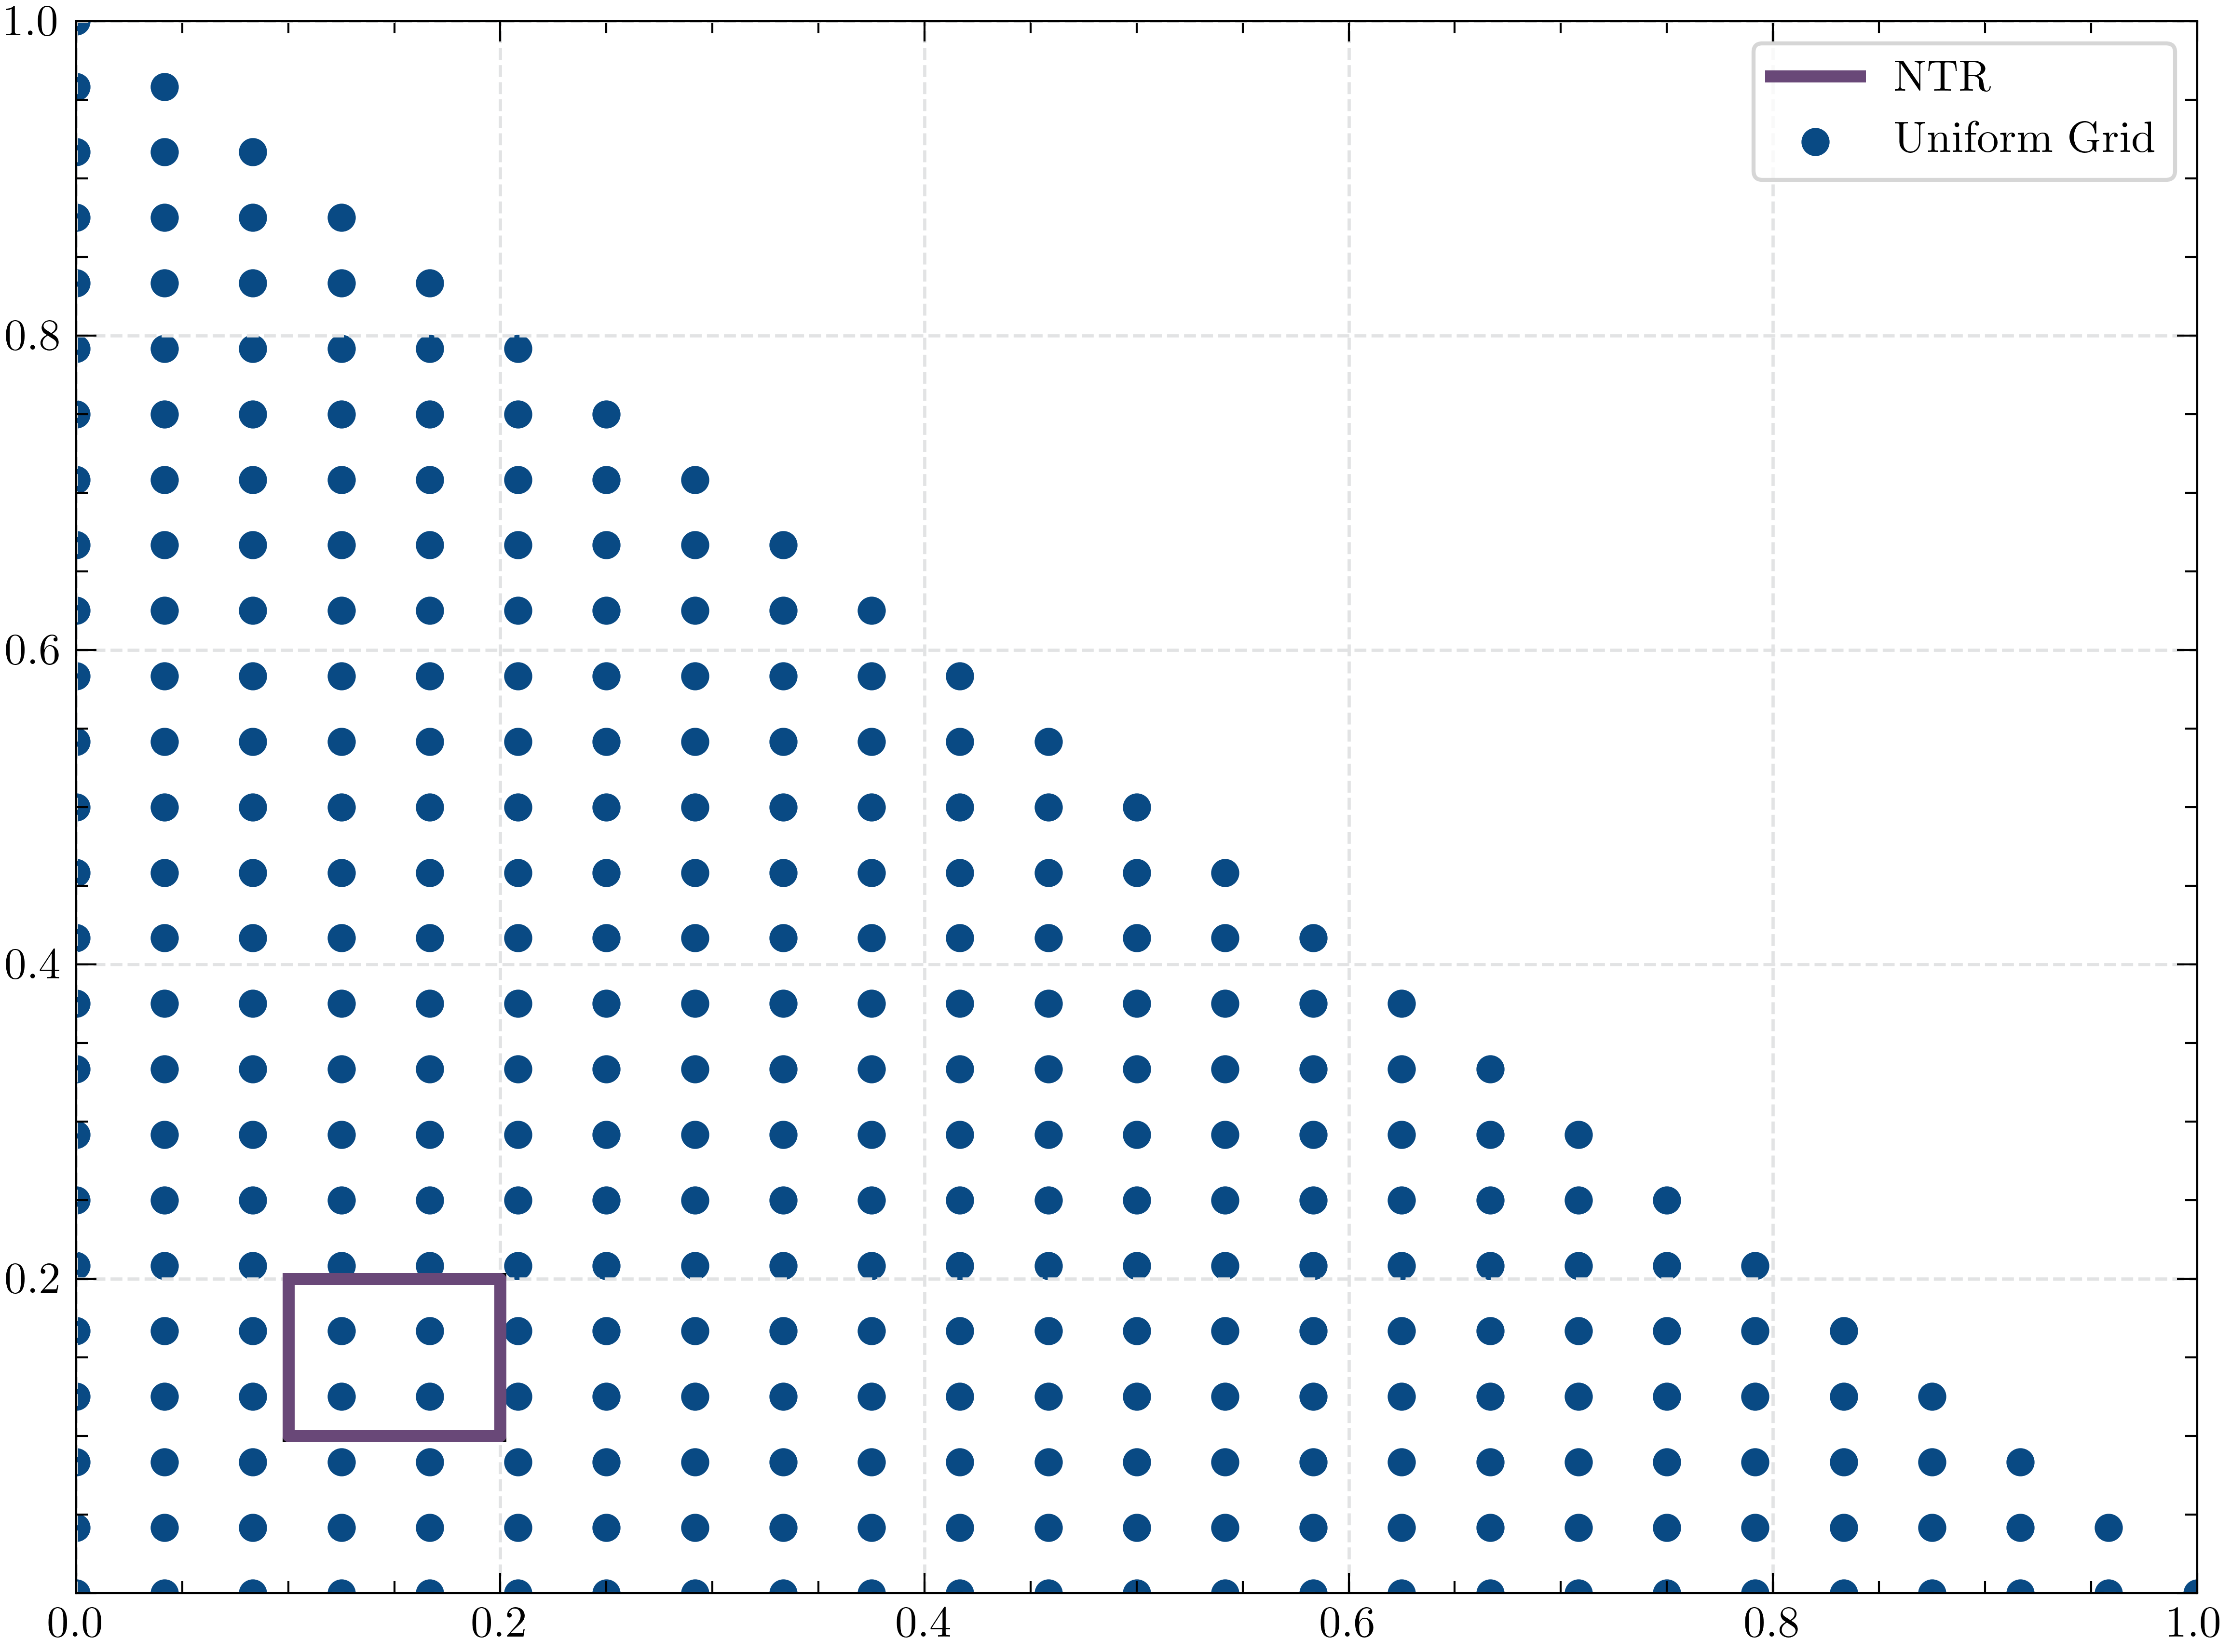

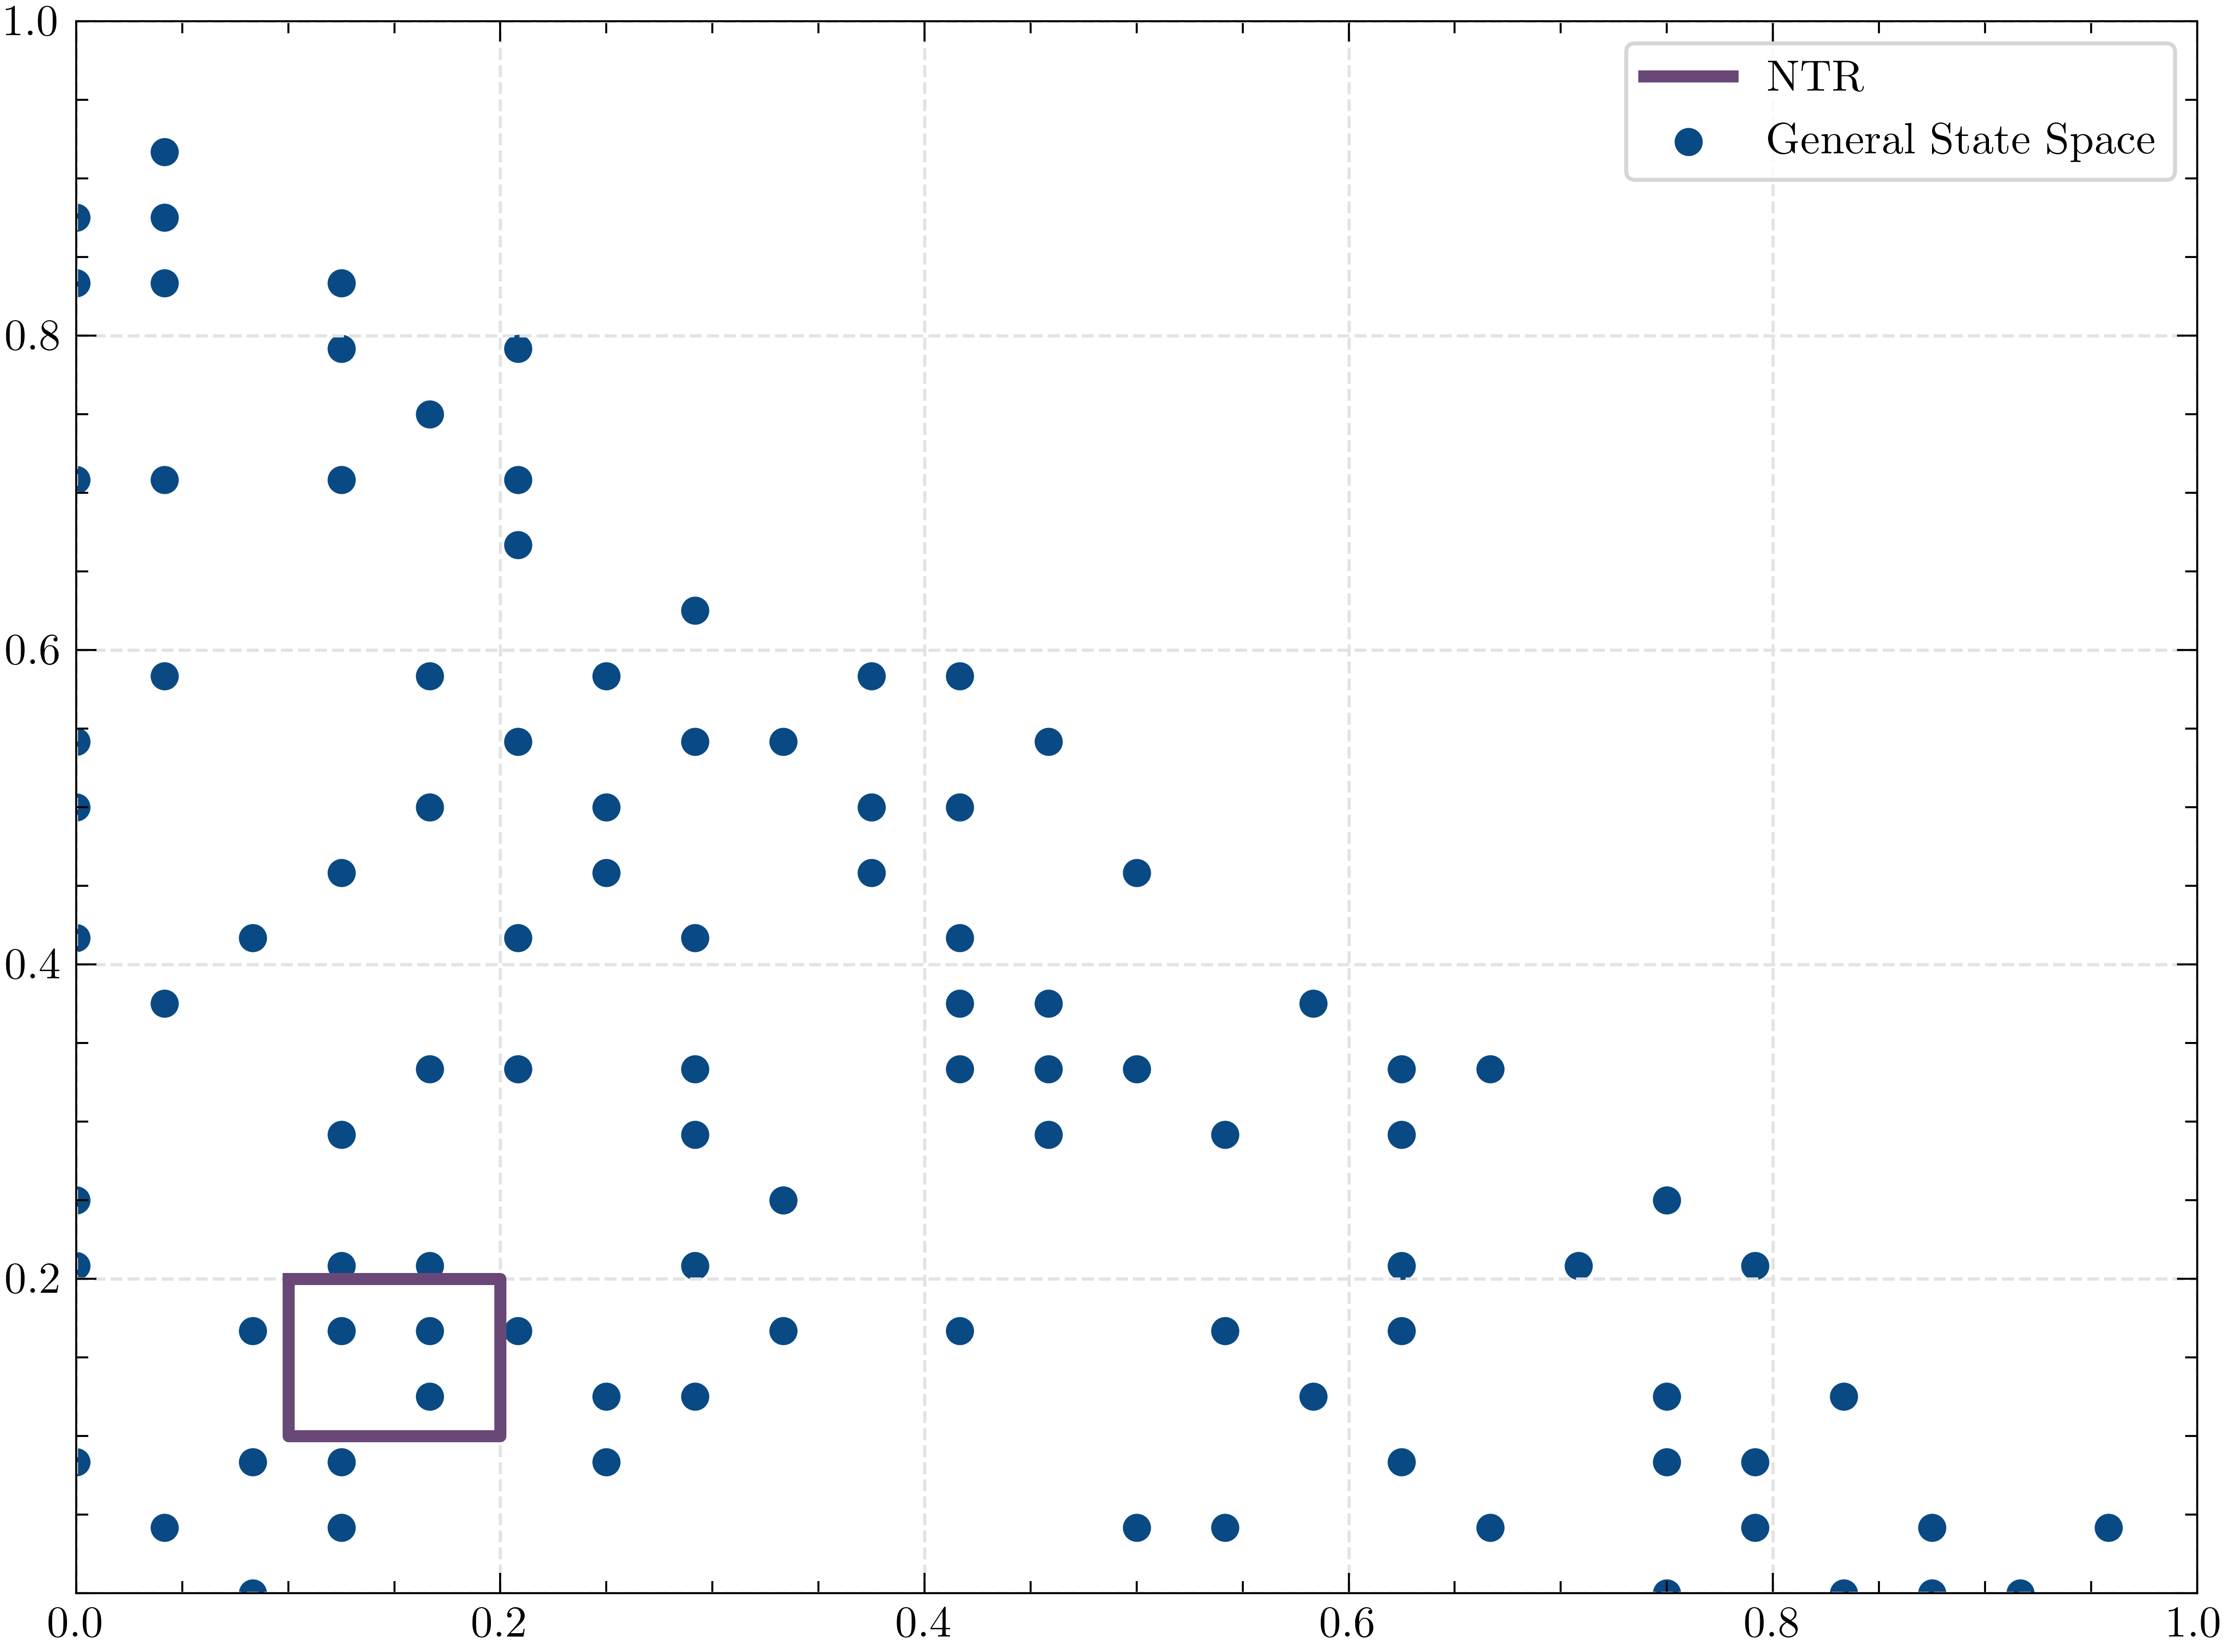

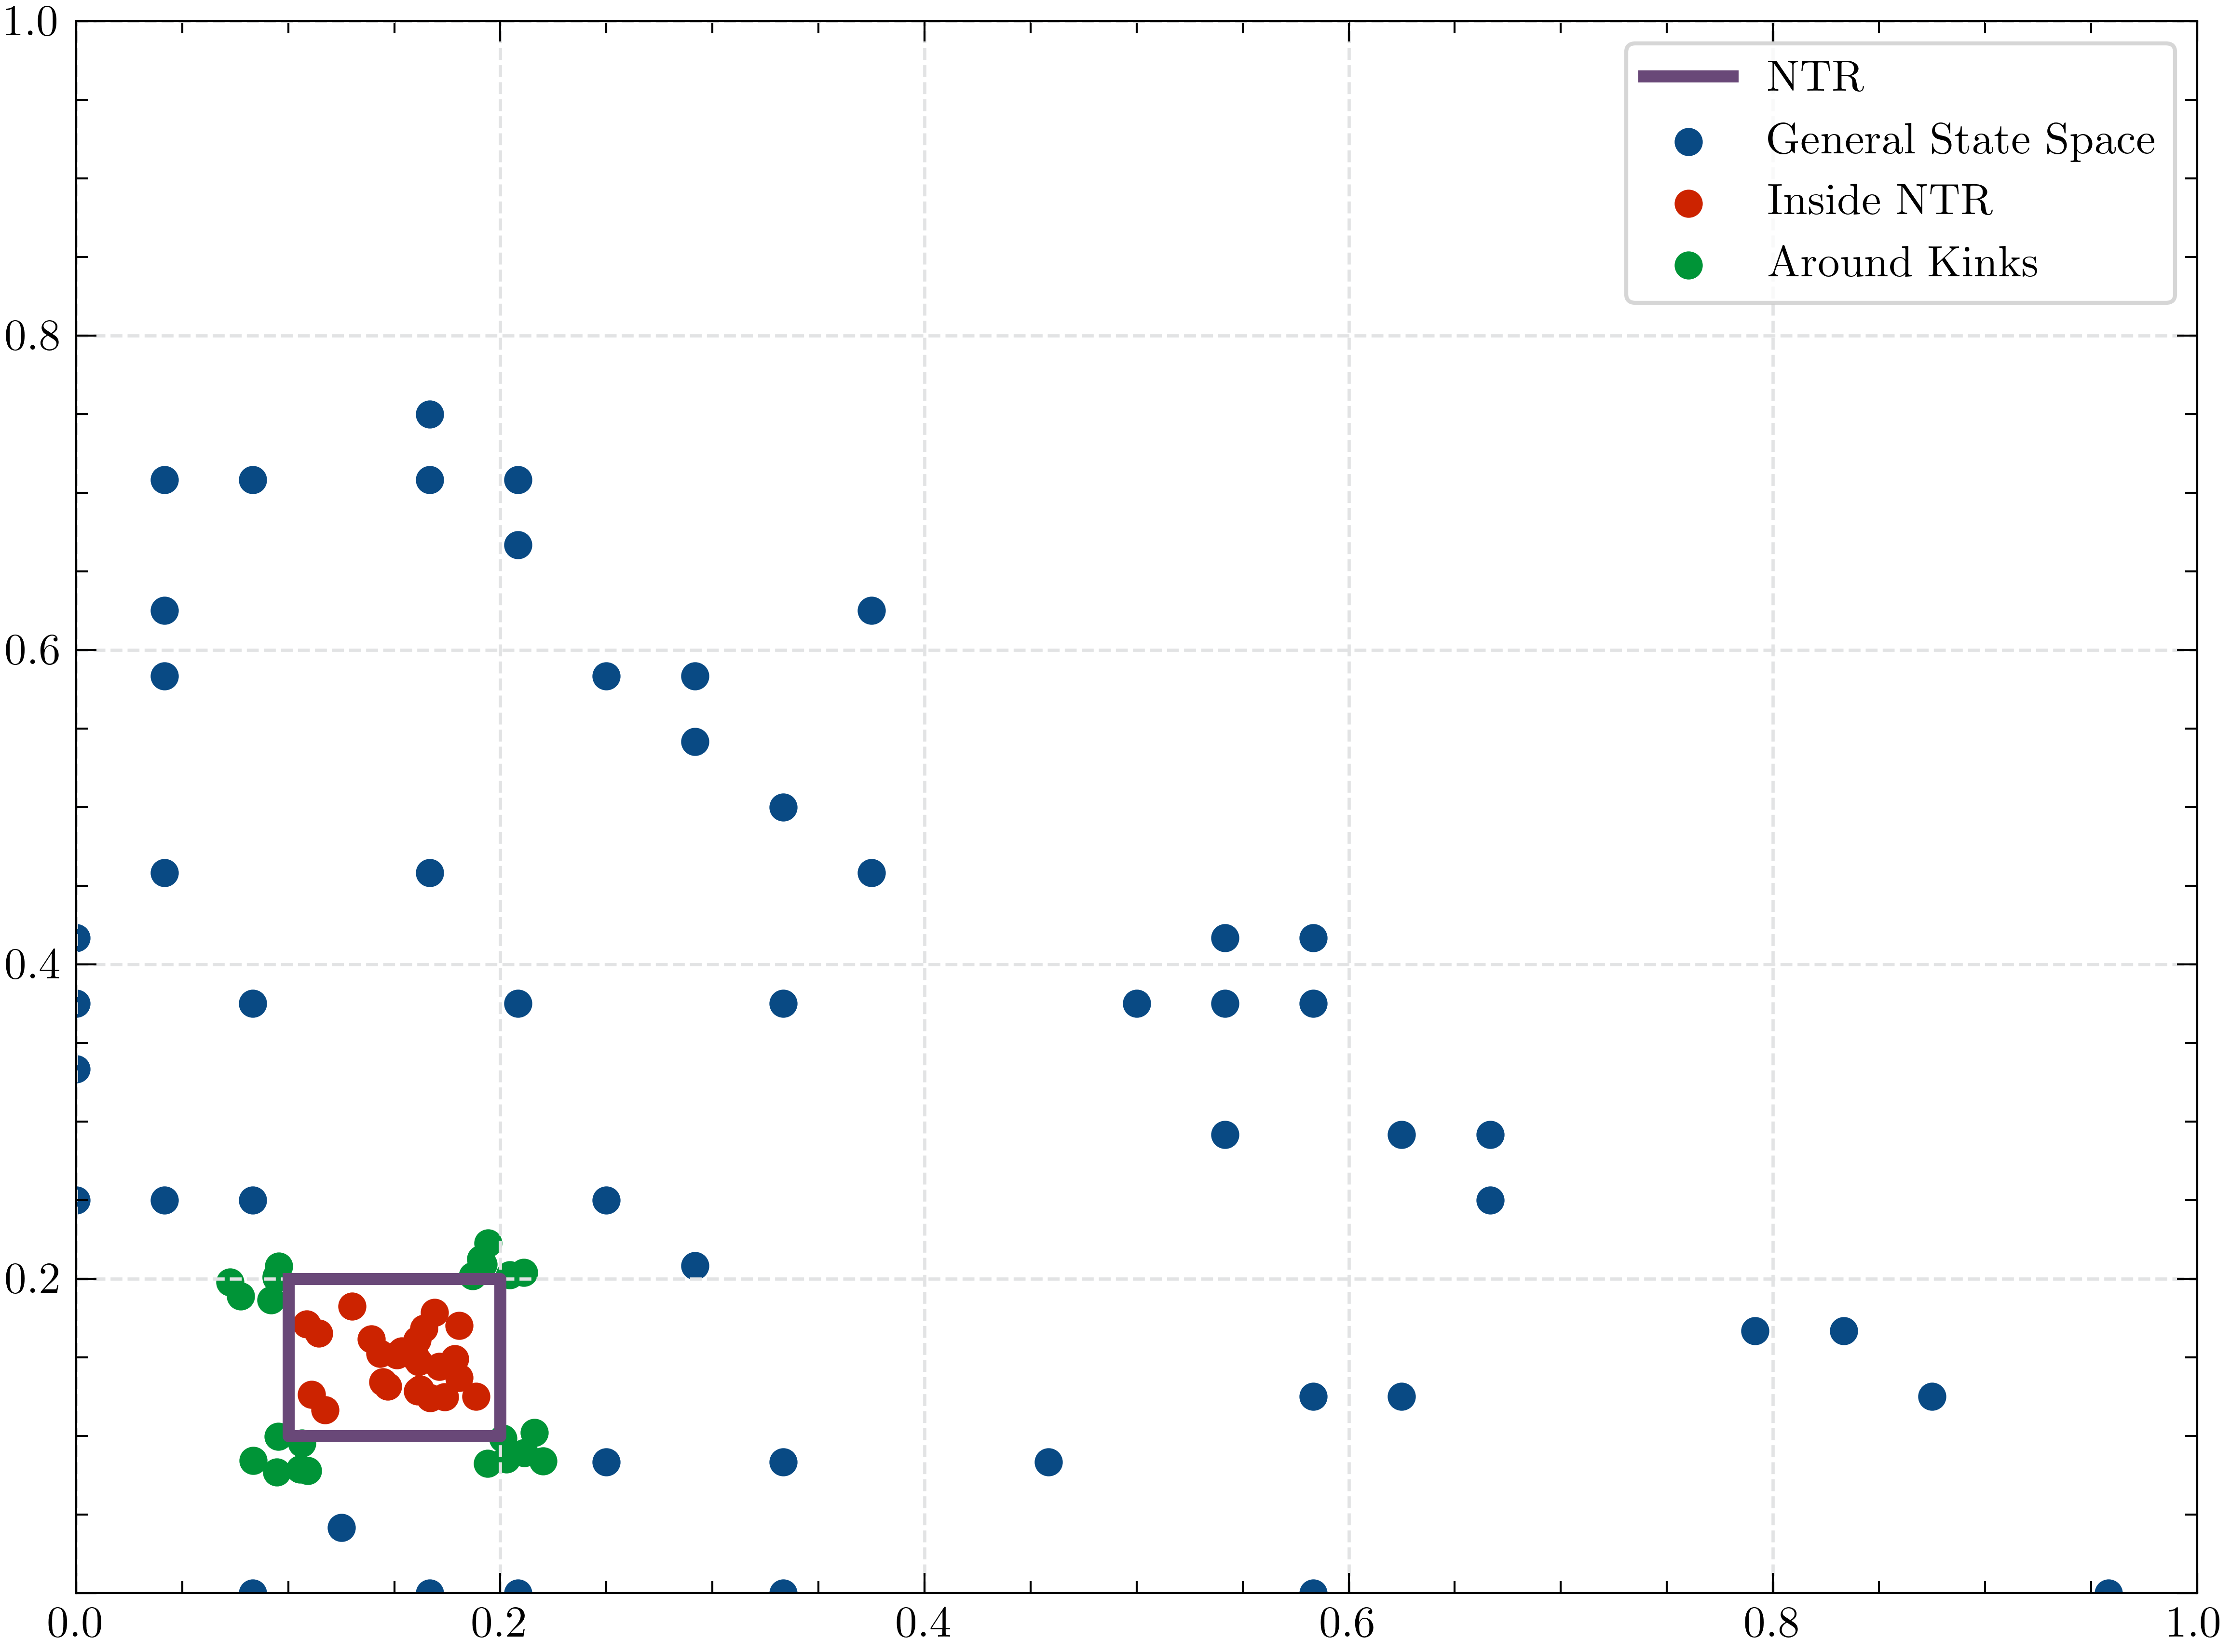

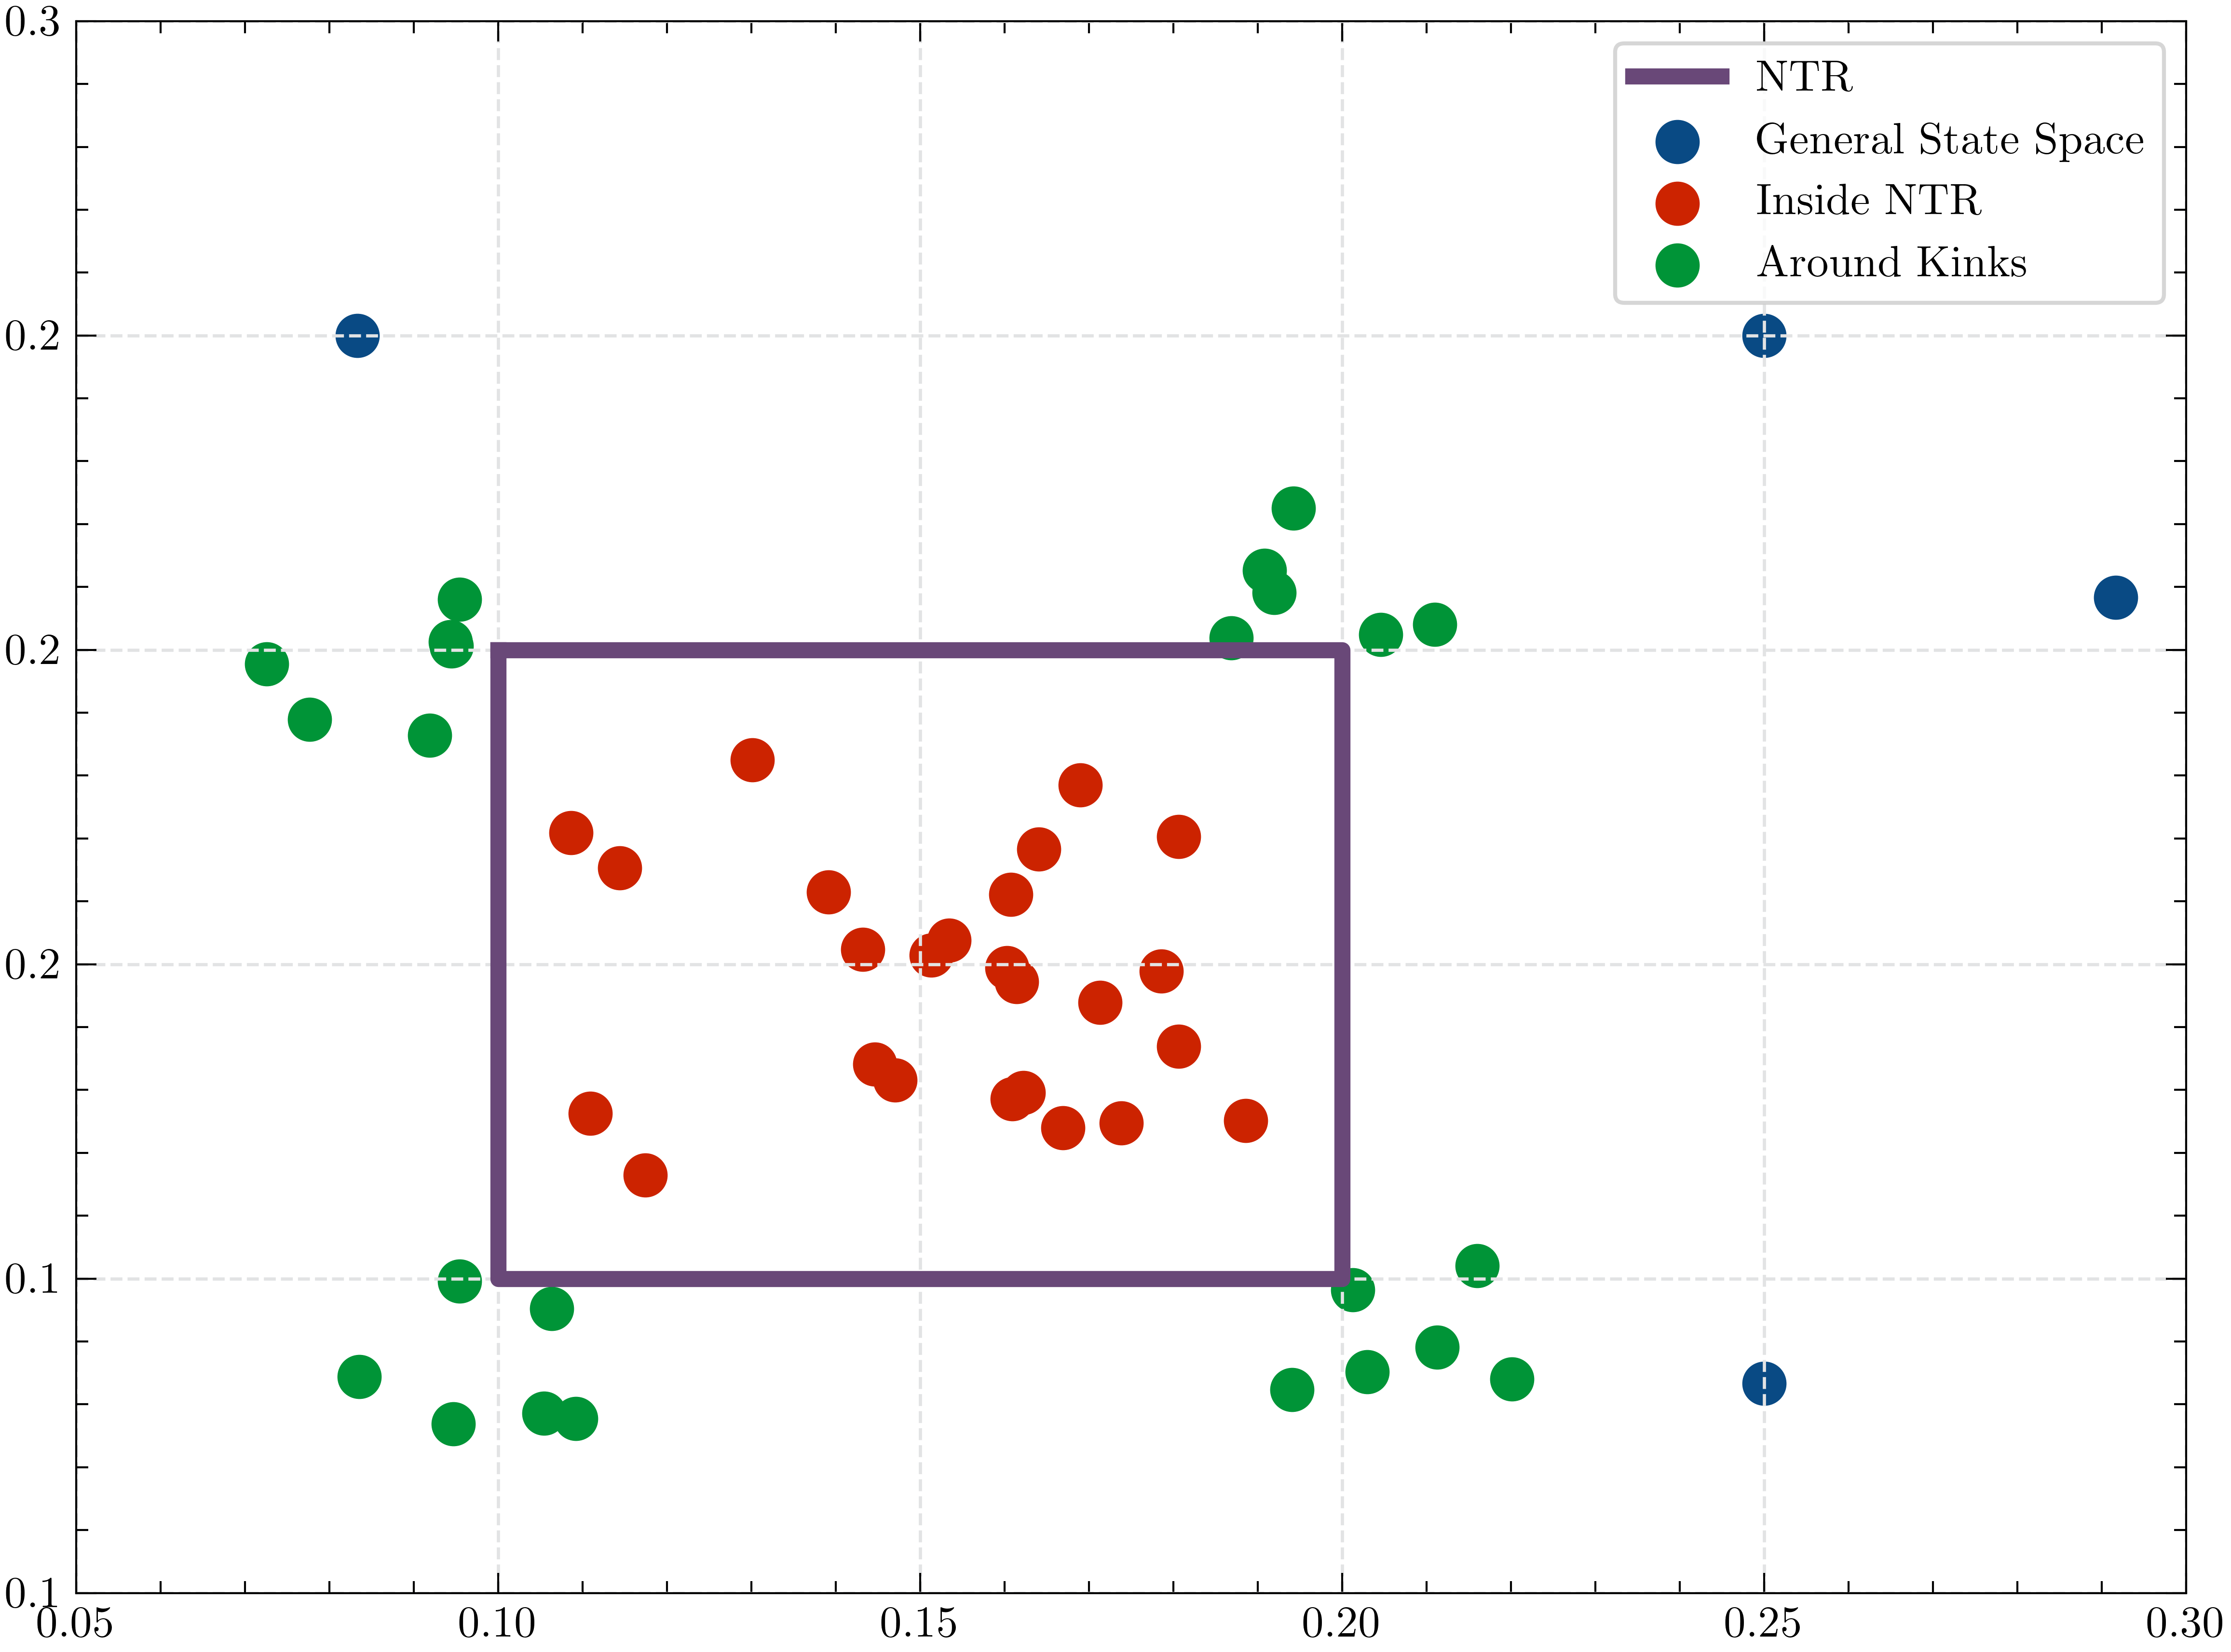

In [16]:
# Define the NTR 
ntr_vertices = np.array([
    [0.1, 0.2],
    [0.2, 0.2],
    [0.2, 0.1],
    [0.1, 0.1]
])

# Sample points
num_samples = 100
np.random.seed(20011210)
points_inside_ntr, points_around_kinks, points_outside_ntr = sample_points_around_ntr_separated(ntr_vertices, num_samples, kink_ratio=0.25, inside_ratio=0.25, grid_density=25)
_, _, naive_points = sample_points_around_ntr_separated(np.array([[-0.5,0.5],[-0.6,-0.6],[-0.7,-0.7]]), num_samples, kink_ratio=0., inside_ratio=0.0, grid_density=25)
uniform_grid = create_grid(ntr_vertices, grid_density=25)
print(f"Number of points inside NTR: {len(points_inside_ntr)}, around kinks: {len(points_around_kinks)}, outside NTR: {len(points_outside_ntr)}")

# Save Uniform grid plot
plt.figure(figsize=(8, 6))
# plt.title('Uniform Grid')
hull = ConvexHull(ntr_vertices)
for simplex in hull.simplices:
    plt.plot(ntr_vertices[simplex, 0], ntr_vertices[simplex, 1], 'k-')
ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR', color=colors[4])
plt.scatter(uniform_grid[:, 0], uniform_grid[:, 1], label='Uniform Grid', color=colors[0])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'uniform_grid.png'))
# plt.close()

# Save Naive sampling strategy plot
plt.figure(figsize=(8, 6))
# plt.title('Naive Sampling Strategy')
hull = ConvexHull(ntr_vertices)
# for simplex in hull.simplices:
#     plt.plot(ntr_vertices[simplex, 0], ntr_vertices[simplex, 1], 'k-')
ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR', color=colors[4])
plt.scatter(naive_points[:, 0], naive_points[:, 1], label='General State Space', color=colors[0])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'naive_sampling_strategy.png'))
# plt.close()


# Save Non-Naive sampling strategy plot
plt.figure(figsize=(8, 6))
# plt.title('Designed Sampling Strategy')
hull = ConvexHull(ntr_vertices)
ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR', color=colors[4],alpha=1.)
plt.scatter(points_outside_ntr[:, 0], points_outside_ntr[:, 1], label='General State Space', color=colors[0])
plt.scatter(points_inside_ntr[:, 0], points_inside_ntr[:, 1], label='Inside NTR', color=colors[1])
plt.scatter(points_around_kinks[:, 0], points_around_kinks[:, 1], label='Around Kinks', color=colors[2] )
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'designed_sampling_strategy.png'))
# plt.close()

# Save Zoomed Non-Naive sampling strategy plot
plt.figure(figsize=(8, 6))
# plt.title('Designed Sampling Strategy')
hull = ConvexHull(ntr_vertices)
# for simplex in hull.simplices:
#     plt.plot(ntr_vertices[simplex, 0], ntr_vertices[simplex, 1], 'k-')
ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR', color=colors[4], linewidth=4,alpha = 1.0)
plt.scatter(points_outside_ntr[:, 0], points_outside_ntr[:, 1], label='General State Space', color=colors[0], s=100)
plt.scatter(points_inside_ntr[:, 0], points_inside_ntr[:, 1], label='Inside NTR', color=colors[1], s=100)
plt.scatter(points_around_kinks[:, 0], points_around_kinks[:, 1], label='Around Kinks', color=colors[2], s=100)
plt.xlim(0.05, 0.3)
plt.ylim(0.05, 0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'zoomed_designed_sampling_strategy.png'))
# plt.close()
